In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.formula.api import ols

from create_dataframes import dataframe_standard, create_df_major
from path_util import data_path
from viz_reg import robust_regression, multivariate_regression, simple_linear_regression, viz_sideways, relative_positive_negative, viz_gender_target

### Load in a dataframe with all links aggregated by occupation group "major"


In [2]:
df_major = create_df_major()
df_major.head(3)

,occ_code,occ_group,occ_title,lenient_links,amount_art,art_per_detailed,lenient_revs,avg_unique_auths,lenient_lengths,avg_art_lengths,...,men_summed,women_summed,white_summed,non_hispanic_white_summed,african_american_summed,asian_summed,hispanic_summed,A_MEAN,A_MEDIAN,education_slope
0,11-0000,major,Management Occupations,"[[""Certified Financial Manager"", ""http://en.wi...",18,0.473684,"{""Certified Financial Manager"": [{""revid"": 581...",406.555556,"{""Certified Financial Manager"": 2611, ""Marketi...",16922.277778,...,0.588000,0.412000,0.827857,0.716143,0.080143,0.065571,0.111714,123370,102450,1.425000
1,13-0000,major,Business and Financial Operations Occupations,"[[""Loan officer"", ""http://en.wikipedia.org/?cu...",10,0.312500,"{""Loan officer"": [{""revid"": 492957605, ""user"":...",227.300000,"{""Loan officer"": 10956, ""Financial adviser"": 2...",11858.700000,...,0.503286,0.496714,0.755000,0.650714,0.114429,0.092143,0.104286,82610,76570,1.642857
2,15-0000,major,Computer and Mathematical Occupations,"[[""Information scientist"", ""http://en.wikipedi...",20,0.952381,"{""Information scientist"": [{""revid"": 329917919...",830.050000,"{""Information scientist"": 2757, ""Software deve...",16940.100000,...,0.694143,0.305857,0.684857,0.610714,0.081286,0.204429,0.074143,99860,97540,2.564286


In [5]:
list(df_major.columns) # all variables

['occ_code',
 'occ_group',
 'occ_title',
 'lenient_links',
 'amount_art',
 'art_per_detailed',
 'lenient_revs',
 'avg_unique_auths',
 'lenient_lengths',
 'avg_art_lengths',
 'men',
 'women',
 'white',
 'non_hispanic_white',
 'african_american',
 'asian',
 'hispanic',
 'men_summed',
 'women_summed',
 'white_summed',
 'non_hispanic_white_summed',
 'african_american_summed',
 'asian_summed',
 'hispanic_summed',
 'A_MEAN',
 'A_MEDIAN',
 'education_slope']

### Variable Explanation

'amount_art', 'art_per_detailed', 'avg_unique_auths', 'avg_art_lengths' are the metrics computed from the wikipedia revision data. amount_art is the amount of articles in a given category, art_per_detailed is amount_art divided by the number of detailed occupations in the category,  avg_unique_auths is how many (unique) authors work on a given site on average and avg_art_lengths are the average lengths of wiki sites in a category.

'men', 'women', 'white', 'non_hispanic_white', 'african_american', 'asian', 'hispanic' is the (average) rate of people belonging to a gender/race/ethnicity within a given category. The summed versions of these are computed by only computing the average with the detailed occupations that have a site matched to them.

'A_MEAN', 'A_MEDIAN' are the annual mean and median income for the category.

'education_slope' represents the slope between 8 ordered rates of education for a given occupation group. (more info in the scripts)

### Quick glance as to how many people of a gender work in a given occupation group

In [19]:
bls_gender_race_excel_path = data_path / "bls" / "gender_race_hispanic" / "cpsaat11_gender, races, hispanic.xlsx"
gender_race_df = pd.read_excel(bls_gender_race_excel_path, skiprows = 6)

women = gender_race_df["Unnamed: 2"][0]/100
white = gender_race_df["Unnamed: 3"][0]/100
african_american = round(gender_race_df["Unnamed: 4"][0]/100, 3)
asian = gender_race_df["Unnamed: 5"][0]/100
hispanic = gender_race_df["Unnamed: 6"][0]/100

employment_dict = {"women": women, "white": white, "non_hispanic_white": white - hispanic,
                "african_american": african_american, "asian": asian, "hispanic": hispanic}
employment_dict

{'women': 0.47,
 'white': 0.775,
 'non_hispanic_white': 0.595,
 'african_american': 0.123,
 'asian': 0.066,
 'hispanic': 0.18}

In [ ]:
relative_positive_negative(df_major, "women", employment_dict) # insert any variable from above dictionary

### Side-by-side plot with simple OLS regression


                            OLS Regression Results                            
Dep. Variable:       avg_unique_auths   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.2694
Date:                Thu, 29 Sep 2022   Prob (F-statistic):              0.610
Time:                        15:19:42   Log-Likelihood:                -137.45
No. Observations:                  20   AIC:                             278.9
Df Residuals:                      18   BIC:                             280.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      421.9056    145.150      2.907   

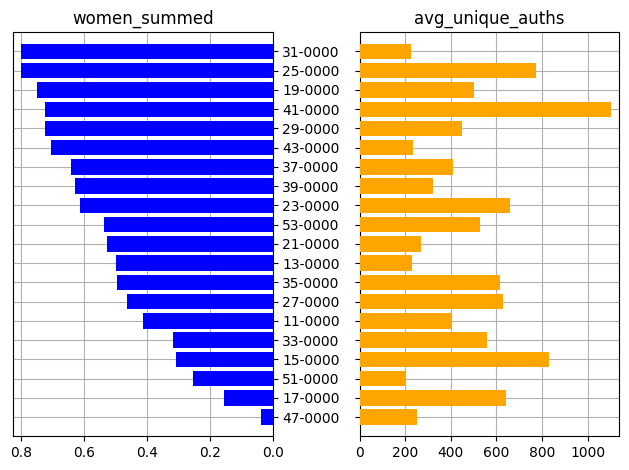

In [7]:
wiki_metric_var = "avg_unique_auths"
race_gender_var = "women_summed"

results = ols((str(wiki_metric_var) + " ~ " + str(race_gender_var)), data=df_major).fit()
print(results.summary())
print("--------------------------------------------------------------------------------------------------")

viz_sideways(df_major, race_gender_var, wiki_metric_var)

### Simple Linear Regression with a visualization

Pearsons correlation is 0.700
The p-value is 0.0005945090348238926


                            OLS Regression Results                            
Dep. Variable:                 A_MEAN   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     17.27
Date:                Thu, 29 Sep 2022   Prob (F-statistic):           0.000595
Time:                        15:19:42   Log-Likelihood:                -226.21
No. Observations:                  20   AIC:                             456.4
Df Residuals:                      18   BIC:                             458.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

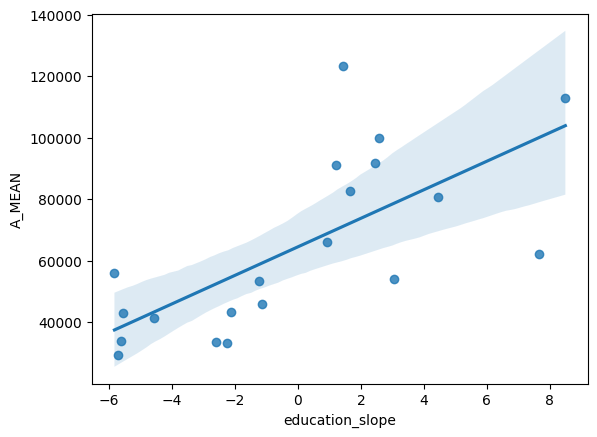

In [8]:
simple_linear_regression(df_major, "A_MEAN", "education_slope") # proof that education increases salary

Pearsons correlation is 0.121
The p-value is 0.6100659258053835


                            OLS Regression Results                            
Dep. Variable:       avg_unique_auths   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                    0.2694
Date:                Thu, 29 Sep 2022   Prob (F-statistic):              0.610
Time:                        15:28:05   Log-Likelihood:                -137.45
No. Observations:                  20   AIC:                             278.9
Df Residuals:                      18   BIC:                             280.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

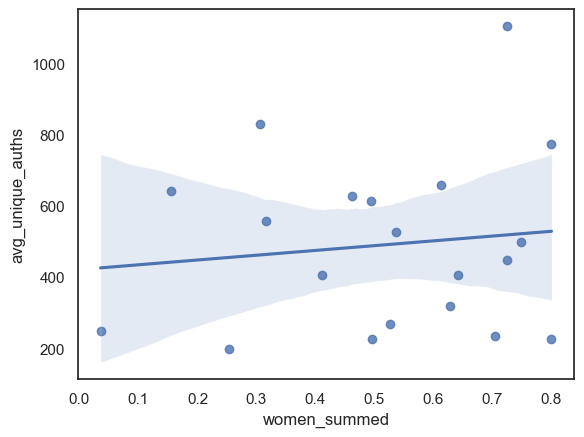

In [15]:
simple_linear_regression(df_major, "avg_unique_auths", "women_summed") # first var is target

### Multivariate Regression

##### In the col_list, we can include any number of variables, for instance for which to control for.
##### Watch out for colinearity!

                            OLS Regression Results                            
Dep. Variable:       avg_unique_auths   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1.794
Date:                Thu, 29 Sep 2022   Prob (F-statistic):              0.196
Time:                        15:30:40   Log-Likelihood:                -135.68
No. Observations:                  20   AIC:                             277.4
Df Residuals:                      17   BIC:                             280.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

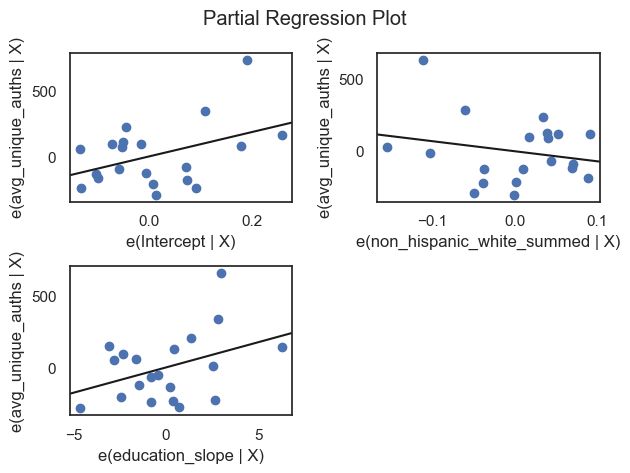

In [17]:
col_list = ["avg_unique_auths", "non_hispanic_white_summed", "education_slope"]

multivariate_regression(df_major, col_list)

The results are hardly significant since there is so much noise within the occupation groups. E.g., "27-0000  Arts, Design, Entertainment, Sports, and Media Occupations" includes 42 detailed occupation titles ranging from Fashion Designers to News Analysts, which may have significantly different values for gender, race, race or education. Thus, relationships should be analyzed on a detailed level.

### Correlation Matrix

##### Shows the correlation between all variables in the df_major. Note that only some of these correlations are actually relevant (e.g., the correlation between %women and %men is perfectly linear for obvious reasons.)

<AxesSubplot:>

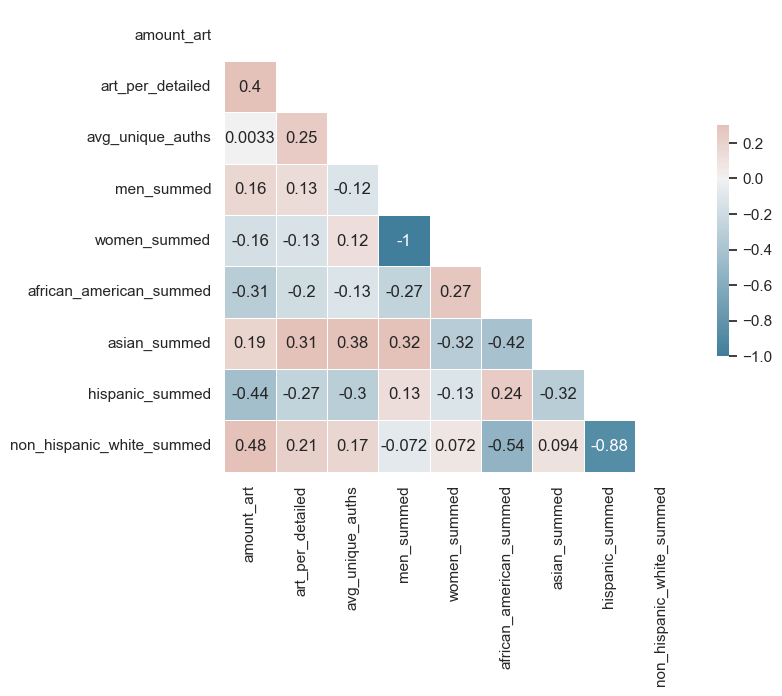

In [18]:
sns.set_theme(style="white")

corr_df = df_major[["amount_art", "art_per_detailed", "avg_unique_auths", "men_summed", "women_summed", 
                    "african_american_summed", "asian_summed", "hispanic_summed", "non_hispanic_white_summed"]].apply(pd.to_numeric)
corr_df.dropna(inplace = True)
corr = corr_df.corr(min_periods = 0)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
